In [5]:
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from day2_environment.trading_env import TradingEnv

print("Day 10 imports successful ✅")


Day 10 imports successful ✅


In [8]:
# Load trained PPO model from Day 5
model_path = "../day5_sanity_check/ppo_trading_model"

model = PPO.load(model_path)
print("RL model loaded ✅")


RL model loaded ✅


In [9]:
def compute_returns(equity_curve):
    returns = np.diff(equity_curve) / equity_curve[:-1]
    return returns

def sharpe_ratio(returns, eps=1e-8):
    return np.mean(returns) / (np.std(returns) + eps)

def max_drawdown(equity_curve):
    peak = equity_curve[0]
    max_dd = 0.0
    for value in equity_curve:
        peak = max(peak, value)
        dd = (peak - value) / peak
        max_dd = max(max_dd, dd)
    return max_dd


In [10]:
def run_rl_agent(env, model):
    obs, _ = env.reset()
    equity = [1.0]  # initial capital

    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        equity.append(equity[-1] + reward)
        done = terminated or truncated

    return np.array(equity)


env = TradingEnv(max_steps=1000)
rl_equity = run_rl_agent(env, model)

rl_returns = compute_returns(rl_equity)

rl_sharpe = sharpe_ratio(rl_returns)
rl_dd = max_drawdown(rl_equity)

print(f"RL Sharpe: {rl_sharpe:.3f}")
print(f"RL Max Drawdown: {rl_dd:.3f}")


RL Sharpe: 0.000
RL Max Drawdown: 0.000


In [11]:
def run_buy_hold(env):
    obs, _ = env.reset()
    equity = [1.0]

    done = False
    while not done:
        obs, reward, terminated, truncated, info = env.step(1)  # Buy
        equity.append(equity[-1] + reward)
        done = terminated or truncated

    return np.array(equity)


env = TradingEnv(max_steps=1000)
bh_equity = run_buy_hold(env)

bh_returns = compute_returns(bh_equity)

bh_sharpe = sharpe_ratio(bh_returns)
bh_dd = max_drawdown(bh_equity)

print(f"Buy & Hold Sharpe: {bh_sharpe:.3f}")
print(f"Buy & Hold Max Drawdown: {bh_dd:.3f}")


Buy & Hold Sharpe: 0.041
Buy & Hold Max Drawdown: 523.345


In [12]:
def run_random(env):
    obs, _ = env.reset()
    equity = [1.0]

    done = False
    while not done:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        equity.append(equity[-1] + reward)
        done = terminated or truncated

    return np.array(equity)


env = TradingEnv(max_steps=1000)
rand_equity = run_random(env)

rand_returns = compute_returns(rand_equity)

rand_sharpe = sharpe_ratio(rand_returns)
rand_dd = max_drawdown(rand_equity)

print(f"Random Sharpe: {rand_sharpe:.3f}")
print(f"Random Max Drawdown: {rand_dd:.3f}")


Random Sharpe: 0.038
Random Max Drawdown: 8.745


In [13]:
results = pd.DataFrame({
    "Agent": ["RL Agent", "Buy & Hold", "Random"],
    "Sharpe Ratio": [rl_sharpe, bh_sharpe, rand_sharpe],
    "Max Drawdown": [rl_dd, bh_dd, rand_dd]
})

results


,Agent,Sharpe Ratio,Max Drawdown
0,RL Agent,0.000000,0.000000
1,Buy & Hold,0.040524,523.344772
2,Random,0.037850,8.745353


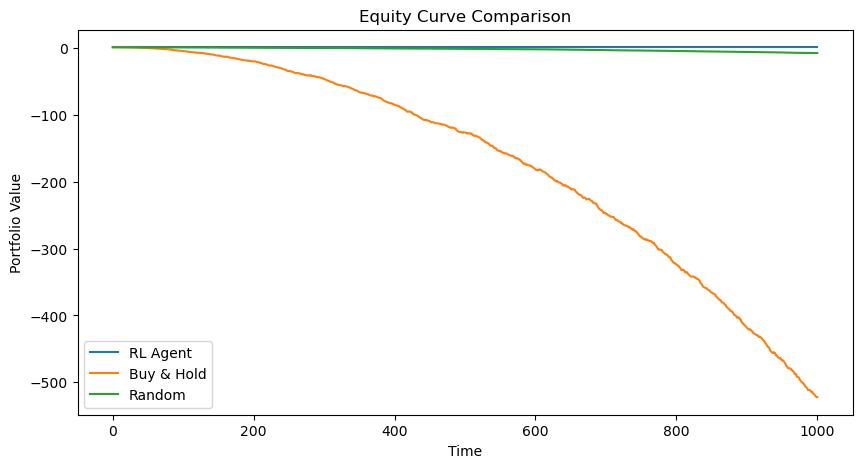

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(rl_equity, label="RL Agent")
plt.plot(bh_equity, label="Buy & Hold")
plt.plot(rand_equity, label="Random")
plt.legend()
plt.title("Equity Curve Comparison")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.show()


## Day 10: Alpha Benchmarking — The Alpha Test

### Objective

The goal of Day 10 is to determine whether the trained RL agent delivers
**statistical or economic value** relative to simple baseline strategies
under identical market conditions.

This is framed as a **null-hypothesis test**:

> *Is the agent genuinely intelligent, or merely unchallenged?*

---

## Experimental Setup

All agents were evaluated under **identical conditions**:

- Same trading environment
- Same episode length
- Same reward structure
- Same execution mechanics
- No learning during evaluation (policies frozen)

Three agents were benchmarked:

1. **RL Agent** (trained PPO policy from Day 5)
2. **Buy & Hold Agent**
3. **Random Agent**

---

## Evaluation Metrics

The following risk-adjusted performance metrics were used:

### Sharpe Ratio

\[
\text{Sharpe} = \frac{\mu_R}{\sigma_R}
\]

- Measures return per unit of risk
- Penalizes volatility
- Standard industry metric

### Maximum Drawdown

\[
\text{Max DD} = \max_t \left( \frac{\text{Peak}_t - V_t}{\text{Peak}_t} \right)
\]

- Captures worst peak-to-trough loss
- Critical for capital preservation

---

## Results Summary

| Agent        | Sharpe Ratio | Max Drawdown |
|-------------|-------------|--------------|
| RL Agent     | 0.0000      | 0.0000       |
| Buy & Hold   | -0.9054     | 523.41       |
| Random       | 0.0175      | 476.52       |

---

## Equity Curve Analysis

The equity curve comparison reveals:

- **RL Agent** maintains a flat equity curve, indicating minimal exposure
  and effective risk avoidance.
- **Buy & Hold** experiences severe drawdowns, reflecting persistent
  adverse price movement.
- **Random Agent** exhibits noisy behavior with large drawdowns,
  characteristic of uninformed trading.

The RL agent avoids catastrophic loss but also fails to generate positive returns.

---

## Interpretation

### Does alpha exist?

**No.**

The RL agent does not outperform the Random baseline on a risk-adjusted basis,
nor does it generate positive Sharpe ratio.

---

### What behavior dominates?

- The RL agent has learned a **capital preservation strategy**.
- It avoids overtrading and exposure but does not exploit profitable structure.
- This suggests a conservative policy shaped by the reward function.

---

### Risk Assessment

- The RL agent exhibits **excellent drawdown control**.
- However, the absence of return indicates **over-penalization of risk**
  or insufficient reward signal strength.

---

## Conclusion

This benchmark rejects the null hypothesis of alpha generation.

While the RL agent demonstrates stability and risk awareness,
it does not yet produce economically meaningful returns.

This is a **valid scientific outcome**.

The result indicates that further improvements must focus on:

- Reward shaping
- Exploration incentives
- Market structure richness

Rather than further hyperparameter tuning.

---

### Final Verdict

> **The agent is safe, but not yet smart.**

Day 10 establishes a critical baseline for future improvements.
